In [11]:
#download from https://github.com/protocolbuffers/protobuf/releases
!pip install protobuf

In [13]:
!git clone --depth 1 https://github.com/tensorflow/models.git

In [14]:
!pip install h5py
!pip install typing-extensions
!pip install wheel

In [15]:
!pip install tensorflow==2.5.0
!pip install tf_slim
!pip install tensorflow-hub
!pip install tensorflow-object-detection-api
!pip install lvis
!pip install matplotlib
!pip install pillow

In [16]:
import tensorflow as tf
import numpy as np
import os
import cv2
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib
import matplotlib.pyplot as plt
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from IPython.display import display
from PIL import Image
from object_detection.utils import label_map_util
from object_detection.protos import string_int_label_map_pb2
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util

In [17]:
#Define the function that detects the object
def detect_object(image_path):
    # Model loading and configuration to detect online
    model_name = 'ssd_inception_v2_coco_2017_11_17'
    model_dir = tf.keras.utils.get_file(
        fname=model_name,
        origin='http://download.tensorflow.org/models/object_detection/' + model_name + '.tar.gz',
        untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"
    model = tf.saved_model.load(str(model_dir))
    detect_fn = model.signatures['serving_default']

    # Loading the image and get the sizes
    #using PIL open the image and convert it to numpy array
    image_np = np.array(Image.open(image_path)) 
    #reshape the image because we need batch for a model
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # detect the object 
    detections = detect_fn(tf.constant(image_np_expanded))
    # Indicates the number of detected objects
    num_detections = int(detections.pop('num_detections'))
    #change the dictionary type to process easily
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)  # Convert class values to integers
    
   
    #labeling
    label_map_path = 'mscoco_label_map.pbtxt'
    with open(label_map_path, 'r') as fid:
        label_map_string = fid.read()

    label_map = string_int_label_map_pb2.StringIntLabelMap()
    from google.protobuf import text_format
    text_format.Merge(label_map_string, label_map)

    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    
    #visualize the output
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        instance_masks=detections.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=18)

    return image_np

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


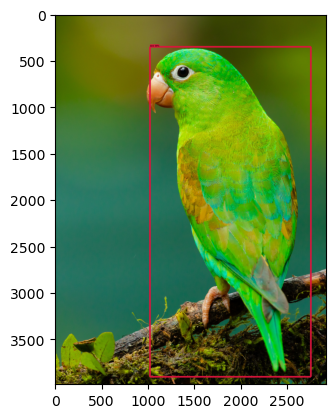

In [18]:
input_image_path = 'bird.jpg'  
output_image = detect_object(input_image_path)

%matplotlib inline
plt.imshow(output_image)
plt.show()
